In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, RandomSampler
import random
import time
import copy

print(f"PyTorch version: {torch.__version__}")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


class BertEmbedding(nn.Module):
    """
    BERT embedding which is the sum of:
    1. Token embeddings
    2. Segment embeddings (sentence A/B)
    3. Position embeddings
    """
    def __init__(self, vocab_size, hidden_size, max_position_embeddings=512, type_vocab_size=2, dropout_prob=0.1):
        super(BertEmbedding, self).__init__()
        self.token_embeddings = nn.Embedding(vocab_size, hidden_size, padding_idx=0)
        self.position_embeddings = nn.Embedding(max_position_embeddings, hidden_size)
        self.segment_embeddings = nn.Embedding(type_vocab_size, hidden_size)

        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)

        # Create position indices tensor
        self.register_buffer(
            "position_ids",
            torch.arange(max_position_embeddings).expand((1, -1))
        )

    def forward(self, input_ids, token_type_ids=None, position_ids=None):
        """
        Args:
            input_ids: Tensor of token ids [batch_size, seq_len]
            token_type_ids: Tensor of segment ids [batch_size, seq_len]
            position_ids: Tensor of position ids [batch_size, seq_len]
        """
        seq_length = input_ids.size(1)

        # Get word embeddings
        word_embeddings = self.token_embeddings(input_ids)

        # Get position embeddings
        if position_ids is None:
            position_ids = self.position_ids[:, :seq_length]
        position_embeddings = self.position_embeddings(position_ids)

        # Get segment embeddings
        if token_type_ids is None:
            token_type_ids = torch.zeros_like(input_ids)
        segment_embeddings = self.segment_embeddings(token_type_ids)

        # Combine embeddings
        embeddings = word_embeddings + position_embeddings + segment_embeddings

        # Apply layer normalization and dropout
        embeddings = self.layer_norm(embeddings)
        embeddings = self.dropout(embeddings)

        return embeddings



class BertSelfAttention(nn.Module):
    """
    Multi-head self-attention mechanism.
    """
    def __init__(self, hidden_size, num_attention_heads, dropout_prob=0.1):
        super(BertSelfAttention, self).__init__()

        self.num_attention_heads = num_attention_heads
        self.attention_head_size = hidden_size // num_attention_heads
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        # Query, Key, Value projections
        self.query = nn.Linear(hidden_size, self.all_head_size)
        self.key = nn.Linear(hidden_size, self.all_head_size)
        self.value = nn.Linear(hidden_size, self.all_head_size)

        # Dropout
        self.dropout = nn.Dropout(dropout_prob)

    def transpose_for_scores(self, x):
        """
        Reshape to [batch_size, num_heads, seq_len, head_size]
        """
        batch_size, seq_len = x.size(0), x.size(1)
        x = x.view(batch_size, seq_len, self.num_attention_heads, self.attention_head_size)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, attention_mask=None):
        """
        Args:
            hidden_states: Tensor of shape [batch_size, seq_len, hidden_size]
            attention_mask: Tensor of shape [batch_size, 1, 1, seq_len]
                           (1 for positions to attend to, 0 for masked positions)
        """
        # Project inputs to queries, keys, and values
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)

        # Reshape for multi-head attention
        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)

        # Take the dot product to get raw attention scores
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)

        # Apply attention mask if provided
        if attention_mask is not None:
            attention_scores = attention_scores + attention_mask

        # Apply softmax to get attention probabilities
        attention_probs = F.softmax(attention_scores, dim=-1)

        # Apply dropout
        attention_probs = self.dropout(attention_probs)

        # Apply attention to values
        context_layer = torch.matmul(attention_probs, value_layer)

        # Reshape back to [batch_size, seq_len, hidden_size]
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        context_layer = context_layer.view(context_layer.size(0), context_layer.size(1), self.all_head_size)

        return context_layer


class BertSelfOutput(nn.Module):
    """
    Output projection and residual connection after self-attention.
    """
    def __init__(self, hidden_size, dropout_prob=0.1):
        super(BertSelfOutput, self).__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, hidden_states, input_tensor):
        """
        Args:
            hidden_states: Output from self-attention
            input_tensor: Original input (for residual connection)
        """
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.layer_norm(hidden_states + input_tensor)
        return hidden_states


# --- Attention Module ---
# This should go in attention.py
class BertAttention(nn.Module):
    """
    Complete self-attention module with output projection.
    """
    def __init__(self, hidden_size, num_attention_heads, dropout_prob=0.1):
        super(BertAttention, self).__init__()
        self.self_attention = BertSelfAttention(hidden_size, num_attention_heads, dropout_prob)
        self.output = BertSelfOutput(hidden_size, dropout_prob)

    def forward(self, input_tensor, attention_mask=None):
        """
        Args:
            input_tensor: Input of shape [batch_size, seq_len, hidden_size]
            attention_mask: Attention mask of shape [batch_size, 1, 1, seq_len]
        """
        self_output = self.self_attention(input_tensor, attention_mask)
        attention_output = self.output(self_output, input_tensor)
        return attention_output



class BertIntermediate(nn.Module):
    """
    Feed-forward intermediate layer.
    """
    def __init__(self, hidden_size, intermediate_size, hidden_act="gelu"):
        super(BertIntermediate, self).__init__()
        self.dense = nn.Linear(hidden_size, intermediate_size)
        self.activation = self._get_activation_fn(hidden_act)

    def _get_activation_fn(self, activation):
        """
        Get activation function by name.
        """
        if activation == "gelu":
            return self._gelu
        else:
            return getattr(F, activation)

    def _gelu(self, x):
        """
        Implementation of GELU activation function.
        """
        return x * 0.5 * (1.0 + torch.erf(x / math.sqrt(2.0)))

    def forward(self, hidden_states):
        """
        Args:
            hidden_states: Input tensor [batch_size, seq_len, hidden_size]
        """
        hidden_states = self.dense(hidden_states)
        hidden_states = self.activation(hidden_states)
        return hidden_states



class BertOutput(nn.Module):
    """
    Output layer for feed-forward network.
    """
    def __init__(self, hidden_size, intermediate_size, dropout_prob=0.1):
        super(BertOutput, self).__init__()
        self.dense = nn.Linear(intermediate_size, hidden_size)
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, hidden_states, input_tensor):
        """
        Args:
            hidden_states: Output from intermediate layer
            input_tensor: Input to the feed-forward (for residual connection)
        """
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        hidden_states = self.layer_norm(hidden_states + input_tensor)
        return hidden_states



class BertLayer(nn.Module):
    """
    A single BERT layer, consisting of attention and feed-forward networks.
    """
    def __init__(self, hidden_size, num_attention_heads, intermediate_size, dropout_prob=0.1):
        super(BertLayer, self).__init__()
        self.attention = BertAttention(hidden_size, num_attention_heads, dropout_prob)
        self.intermediate = BertIntermediate(hidden_size, intermediate_size)
        self.output = BertOutput(hidden_size, intermediate_size, dropout_prob)

    def forward(self, hidden_states, attention_mask=None):
        """
        Args:
            hidden_states: Input tensor [batch_size, seq_len, hidden_size]
            attention_mask: Attention mask [batch_size, 1, 1, seq_len]
        """
        # Self-attention with residual connection
        attention_output = self.attention(hidden_states, attention_mask)

        # Feed-forward network with residual connection
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output, attention_output)

        return layer_output



class BertEncoder(nn.Module):
    """
    Stack of BERT layers.
    """
    def __init__(self, hidden_size, num_attention_heads, intermediate_size, num_hidden_layers, dropout_prob=0.1):
        super(BertEncoder, self).__init__()

        # Create stack of BERT layers
        self.layers = nn.ModuleList([
            BertLayer(hidden_size, num_attention_heads, intermediate_size, dropout_prob)
            for _ in range(num_hidden_layers)
        ])

    def forward(self, hidden_states, attention_mask=None):
        """
        Args:
            hidden_states: Input tensor [batch_size, seq_len, hidden_size]
            attention_mask: Attention mask [batch_size, 1, 1, seq_len]
        """
        all_encoder_layers = []

        # Process through BERT layers
        for layer in self.layers:
            hidden_states = layer(hidden_states, attention_mask)
            all_encoder_layers.append(hidden_states)

        return all_encoder_layers



class BertPooler(nn.Module):
    """
    Pool the output of the BERT encoder for tasks like classification.
    Takes the first token ([CLS]) representation and applies a linear layer.
    """
    def __init__(self, hidden_size):
        super(BertPooler, self).__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        """
        Args:
            hidden_states: Last layer hidden state [batch_size, seq_len, hidden_size]
        """
        # Take [CLS] token representation (first token)
        first_token_tensor = hidden_states[:, 0]

        # Apply linear transformation and activation
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)

        return pooled_output


PyTorch version: 2.0.0+cu117
Using device: cpu


In [2]:

class BertPreTrainingHeads(nn.Module):
    """
    Heads for pre-training tasks:
    1. Masked Language Modeling (MLM)
    2. Next Sentence Prediction (NSP)
    """
    def __init__(self, hidden_size, vocab_size):
        super(BertPreTrainingHeads, self).__init__()

        # MLM head
        self.predictions = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.LayerNorm(hidden_size),
            nn.Linear(hidden_size, vocab_size)
        )

        # NSP head
        self.seq_relationship = nn.Linear(hidden_size, 2)

    def forward(self, sequence_output, pooled_output):
        """
        Args:
            sequence_output: Output from BERT encoder [batch_size, seq_len, hidden_size]
            pooled_output: Pooled output for [CLS] token [batch_size, hidden_size]
        """
        # MLM prediction
        prediction_scores = self.predictions(sequence_output)

        # NSP prediction
        seq_relationship_score = self.seq_relationship(pooled_output)

        return prediction_scores, seq_relationship_score


class BertModel(nn.Module):
    """
    Base BERT model without specific heads.
    """
    def __init__(self, vocab_size, hidden_size=768, num_hidden_layers=12,
                 num_attention_heads=12, intermediate_size=3072,
                 max_position_embeddings=512, type_vocab_size=2, dropout_prob=0.1):
        super(BertModel, self).__init__()

        # Initialize components
        self.embeddings = BertEmbedding(
            vocab_size=vocab_size,
            hidden_size=hidden_size,
            max_position_embeddings=max_position_embeddings,
            type_vocab_size=type_vocab_size,
            dropout_prob=dropout_prob
        )

        self.encoder = BertEncoder(
            hidden_size=hidden_size,
            num_attention_heads=num_attention_heads,
            intermediate_size=intermediate_size,
            num_hidden_layers=num_hidden_layers,
            dropout_prob=dropout_prob
        )

        self.pooler = BertPooler(hidden_size)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, position_ids=None):
        """
        Args:
            input_ids: Tensor of token ids [batch_size, seq_len]
            token_type_ids: Tensor of segment ids [batch_size, seq_len]
            attention_mask: Mask to avoid attention on padding tokens [batch_size, seq_len]
            position_ids: Tensor of position ids [batch_size, seq_len]
        """
        # If attention mask is provided, convert it to the format expected by the model
        if attention_mask is not None:
            # Convert to [batch_size, 1, 1, seq_len] and to dtype float
            extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)

            # Convert mask of 1s and 0s to mask of 0s and -10000s
            extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0
        else:
            extended_attention_mask = None

        # Embedding layer
        embedding_output = self.embeddings(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            position_ids=position_ids
        )

        # Encoder layers
        all_encoder_layers = self.encoder(
            hidden_states=embedding_output,
            attention_mask=extended_attention_mask
        )

        # Get the last layer output
        sequence_output = all_encoder_layers[-1]

        # Pool the output (for [CLS] token)
        pooled_output = self.pooler(sequence_output)

        return sequence_output, pooled_output, all_encoder_layers


class BertForPreTraining(nn.Module):
    """
    BERT model with pre-training heads.
    """
    def __init__(self, vocab_size, hidden_size=768, num_hidden_layers=12,
                 num_attention_heads=12, intermediate_size=3072,
                 max_position_embeddings=512, type_vocab_size=2, dropout_prob=0.1):
        super(BertForPreTraining, self).__init__()

        # BERT model
        self.bert = BertModel(
            vocab_size=vocab_size,
            hidden_size=hidden_size,
            num_hidden_layers=num_hidden_layers,
            num_attention_heads=num_attention_heads,
            intermediate_size=intermediate_size,
            max_position_embeddings=max_position_embeddings,
            type_vocab_size=type_vocab_size,
            dropout_prob=dropout_prob
        )

        # Pre-training heads
        self.cls = BertPreTrainingHeads(hidden_size, vocab_size)

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """
        Initialize the weights.
        """
        if isinstance(module, nn.Linear):
            # Initialize linear weights with normal distribution
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            # Initialize embedding weights with normal distribution
            module.weight.data.normal_(mean=0.0, std=0.02)
            if hasattr(module, 'padding_idx') and module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            # Initialize layer normalization parameters
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None,
                masked_lm_labels=None, next_sentence_label=None):
        """
        Args:
            input_ids: Tensor of token ids [batch_size, seq_len]
            token_type_ids: Tensor of segment ids [batch_size, seq_len]
            attention_mask: Mask to avoid attention on padding tokens [batch_size, seq_len]
            masked_lm_labels: Labels for masked tokens [batch_size, seq_len]
            next_sentence_label: Labels for next sentence prediction [batch_size]
        """
        # Forward pass through BERT
        sequence_output, pooled_output, _ = self.bert(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask
        )

        # Get prediction scores for masked tokens and next sentence
        prediction_scores, seq_relationship_score = self.cls(sequence_output, pooled_output)

        # Calculate loss if labels are provided
        if masked_lm_labels is not None and next_sentence_label is not None:
            # Loss for masked language modeling
            masked_lm_criterion = nn.CrossEntropyLoss(ignore_index=-1)
            masked_lm_loss = masked_lm_criterion(
                prediction_scores.view(-1, self.cls.predictions[-1].out_features),
                masked_lm_labels.view(-1)
            )

            # Loss for next sentence prediction
            next_sentence_criterion = nn.CrossEntropyLoss()
            next_sentence_loss = next_sentence_criterion(
                seq_relationship_score.view(-1, 2),
                next_sentence_label.view(-1)
            )

            # Total loss
            total_loss = masked_lm_loss + next_sentence_loss

            return total_loss, prediction_scores, seq_relationship_score
        else:
            return prediction_scores, seq_relationship_score







In [3]:
class ToyBertDataset(Dataset):
    """
    A toy dataset for BERT pre-training.
    """
    def __init__(self, vocab_size=10000, seq_length=128, num_samples=1000, mask_token_id=103, cls_token_id=101, sep_token_id=102):
        self.vocab_size = vocab_size
        self.seq_length = seq_length
        self.num_samples = num_samples
        self.mask_token_id = mask_token_id
        self.cls_token_id = cls_token_id
        self.sep_token_id = sep_token_id

        # Generate data
        self.data = self._generate_data()

    def _generate_data(self):
        """
        Generate synthetic data for pre-training.
        """
        data = []

        for _ in range(self.num_samples):
            # Generate two random sentences
            sentence1_length = random.randint(10, 40)
            sentence2_length = min(self.seq_length - sentence1_length - 3, 40)  # -3 for [CLS] and [SEP] tokens

            sentence1 = torch.randint(1000, self.vocab_size - 4, (sentence1_length,))  # -4 for special tokens
            sentence2 = torch.randint(1000, self.vocab_size - 4, (sentence2_length,))

            # 50% are actual next sentences
            is_next = random.choice([0, 1])
            if is_next:
                second_sentence = sentence2
            else:
                # Select a random sentence for negative example
                second_sentence = torch.randint(1000, self.vocab_size - 4, (sentence2_length,))

            # Build input sequence
            # [CLS] sentence1 [SEP] sentence2 [SEP]
            tokens = torch.cat([
                torch.tensor([self.cls_token_id]),
                sentence1,
                torch.tensor([self.sep_token_id]),
                second_sentence,
                torch.tensor([self.sep_token_id])
            ])

            # Pad sequence if necessary
            padding_length = self.seq_length - tokens.size(0)
            if padding_length > 0:
                tokens = torch.cat([tokens, torch.zeros(padding_length, dtype=torch.long)])

            # Create segment ids (0 for sentence1, 1 for sentence2)
            segment_ids = torch.cat([
                torch.zeros(sentence1_length + 2, dtype=torch.long),  # +2 for [CLS] and [SEP]
                torch.ones(sentence2_length + 1, dtype=torch.long),   # +1 for [SEP]
                torch.zeros(padding_length, dtype=torch.long)
            ])

            # Create attention mask (1 for real tokens, 0 for padding)
            attention_mask = (tokens != 0).long()

            # Create input sequence and MLM labels
            masked_tokens, masked_lm_labels = self._create_masked_lm_predictions(tokens.clone())

            # Store sample
            data.append({
                'input_ids': masked_tokens,
                'token_type_ids': segment_ids,
                'attention_mask': attention_mask,
                'masked_lm_labels': masked_lm_labels,
                'next_sentence_label': torch.tensor(is_next, dtype=torch.long)
            })

        return data

    def _create_masked_lm_predictions(self, tokens):
        """
        Create masked tokens for Masked Language Modeling.
        """
        # Work on a copy to avoid modifying the original
        labels = tokens.clone()

        # Set label for non-masked tokens to -1
        labels.fill_(-1)

        # Find eligible tokens for masking (exclude [CLS], [SEP], padding)
        eligible_indices = []
        for i, token in enumerate(tokens):
            if token not in [self.cls_token_id, self.sep_token_id, 0]:
                eligible_indices.append(i)

        # Shuffle indices
        random.shuffle(eligible_indices)

        # Mask 15% of eligible tokens
        num_to_mask = max(1, int(round(len(eligible_indices) * 0.15)))
        masked_indices = eligible_indices[:num_to_mask]

        # For those 15% tokens:
        for index in masked_indices:
            prob = random.random()

            # 80% chance: replace with [MASK]
            if prob < 0.8:
                tokens[index] = self.mask_token_id
            # 10% chance: replace with random word
            elif prob < 0.9:
                tokens[index] = random.randint(1000, self.vocab_size - 4)
            # 10% chance: keep the original token

            # Set the label for this position to the original token
            labels[index] = tokens[index].clone()

        return tokens, labels

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        """
        Get a sample from the dataset.
        """
        sample = self.data[idx]

        return (
            sample['input_ids'],
            sample['token_type_ids'],
            sample['attention_mask'],
            sample['masked_lm_labels'],
            sample['next_sentence_label']
        )


# --- Training Function ---
def train_bert(model, dataloader, optimizer, num_epochs, device):
    """
    Train the BERT model on the pre-training objectives.
    """
    model.train()
    losses = []

    for epoch in range(num_epochs):
        total_loss = 0

        for batch_idx, batch in enumerate(dataloader):
            # Move batch to device
            batch = tuple(t.to(device) for t in batch)
            input_ids, token_type_ids, attention_mask, masked_lm_labels, next_sentence_labels = batch

            # Forward pass
            optimizer.zero_grad()

            loss, _, _ = model(
                input_ids=input_ids,
                token_type_ids=token_type_ids,
                attention_mask=attention_mask,
                masked_lm_labels=masked_lm_labels,
                next_sentence_label=next_sentence_labels
            )

            # Backward pass
            loss.backward()

            # Update parameters
            optimizer.step()

            # Track loss
            total_loss += loss.item()

            # Print progress
            if (batch_idx + 1) % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{len(dataloader)}, Loss: {loss.item():.4f}')

        # Calculate average loss
        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}')

    return losses



Epoch 1/3, Batch 10/63, Loss: 8.7117
Epoch 1/3, Batch 20/63, Loss: 7.7984
Epoch 1/3, Batch 30/63, Loss: 7.1211
Epoch 1/3, Batch 40/63, Loss: 6.6906
Epoch 1/3, Batch 50/63, Loss: 6.2311
Epoch 1/3, Batch 60/63, Loss: 5.9785
Epoch 1/3, Average Loss: 7.2695
Epoch 2/3, Batch 10/63, Loss: 5.4478
Epoch 2/3, Batch 20/63, Loss: 5.7022
Epoch 2/3, Batch 30/63, Loss: 5.4199
Epoch 2/3, Batch 40/63, Loss: 5.1655
Epoch 2/3, Batch 50/63, Loss: 4.8453
Epoch 2/3, Batch 60/63, Loss: 4.7265
Epoch 2/3, Average Loss: 5.2421
Epoch 3/3, Batch 10/63, Loss: 4.0842
Epoch 3/3, Batch 20/63, Loss: 4.4885
Epoch 3/3, Batch 30/63, Loss: 4.0407
Epoch 3/3, Batch 40/63, Loss: 4.6307
Epoch 3/3, Batch 50/63, Loss: 4.3409
Epoch 3/3, Batch 60/63, Loss: 4.2853
Epoch 3/3, Average Loss: 4.4209


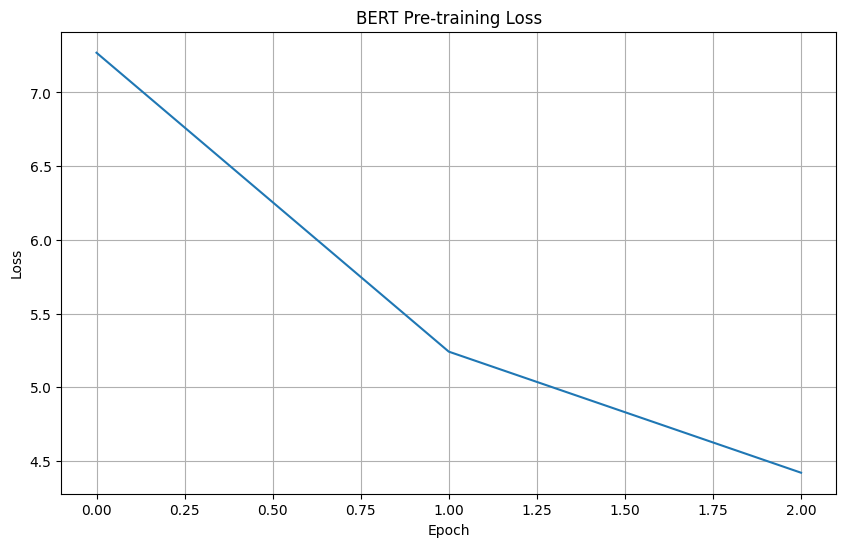


Masked Language Model Predictions:
--------------------------------------------------
Position 18: Token=103, Predicted=103, Actual=103
Position 21: Token=103, Predicted=103, Actual=103
Position 26: Token=103, Predicted=103, Actual=103
Position 31: Token=1487, Predicted=103, Actual=1487
Position 43: Token=103, Predicted=103, Actual=103
Position 48: Token=103, Predicted=103, Actual=103
Position 49: Token=103, Predicted=103, Actual=103
Position 53: Token=6944, Predicted=103, Actual=6944
Position 60: Token=103, Predicted=103, Actual=103
Position 61: Token=103, Predicted=103, Actual=103

Next Sentence Prediction:
--------------------------------------------------
Predicted: NotNext, Actual: NotNext

MLM Accuracy: 80.00%
Epoch 1/3:
  Train Loss: 0.6892
  Validation Accuracy: 0.6500
Epoch 2/3:
  Train Loss: 0.6904
  Validation Accuracy: 0.6500
Epoch 3/3:
  Train Loss: 0.6928
  Validation Accuracy: 0.6500


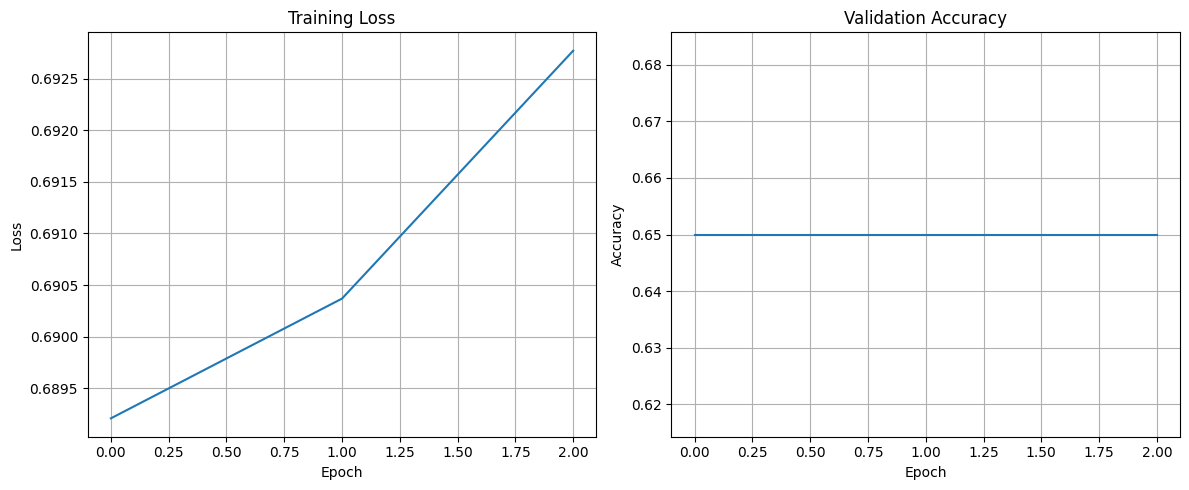

In [ ]:
# --- Model Hyperparameters ---
vocab_size = 10000
hidden_size = 256
num_hidden_layers = 4
num_attention_heads = 4
intermediate_size = 1024
max_position_embeddings = 512
type_vocab_size = 2
dropout_prob = 0.1
batch_size = 8
num_epochs = 3

# --- Create Toy Dataset ---
dataset = ToyBertDataset(
    vocab_size=vocab_size,
    seq_length=128,
    num_samples=500
)

dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)

# --- Initialize Model ---
model = BertForPreTraining(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    num_hidden_layers=num_hidden_layers,
    num_attention_heads=num_attention_heads,
    intermediate_size=intermediate_size,
    max_position_embeddings=max_position_embeddings,
    type_vocab_size=type_vocab_size,
    dropout_prob=dropout_prob
).to(device)

# --- Optimizer ---
optimizer = optim.Adam(model.parameters(), lr=3e-5)

# --- Train the Model ---
losses = train_bert(model, dataloader, optimizer, num_epochs, device)

# --- Plot Training Loss ---
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BERT Pre-training Loss')
plt.grid(True)
plt.show()

# --- Inspect Masked Language Model Predictions ---
def test_mlm_prediction():
    """
    Run a sample through the model and check MLM predictions.
    """
    model.eval()

    # Get a random sample
    sample_idx = random.randint(0, len(dataset) - 1)
    input_ids, token_type_ids, attention_mask, masked_lm_labels, next_sentence_label = [t.unsqueeze(0).to(device) for t in dataset[sample_idx]]

    # Forward pass
    with torch.no_grad():
        prediction_scores, seq_relationship_score = model(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask
        )

    # Get predictions for masked tokens
    predictions = torch.argmax(prediction_scores, dim=-1)

    # Convert to numpy for easier inspection
    input_ids_np = input_ids.cpu().numpy()[0]
    predictions_np = predictions.cpu().numpy()[0]
    masked_lm_labels_np = masked_lm_labels.cpu().numpy()[0]

    # Print results
    print("\nMasked Language Model Predictions:")
    print("-" * 50)

    for i, (token_id, pred, label) in enumerate(zip(input_ids_np, predictions_np, masked_lm_labels_np)):
        if label != -1:  # This was a masked position
            print(f"Position {i}: Token={token_id}, Predicted={pred}, Actual={label}")

    # Check next sentence prediction
    nsp_pred = torch.argmax(seq_relationship_score, dim=-1).item()
    nsp_actual = next_sentence_label.item()

    print("\nNext Sentence Prediction:")
    print("-" * 50)
    print(f"Predicted: {'IsNext' if nsp_pred == 1 else 'NotNext'}, Actual: {'IsNext' if nsp_actual == 1 else 'NotNext'}")

    # Calculate MLM accuracy
    correct = 0
    total = 0

    for pred, label in zip(predictions_np, masked_lm_labels_np):
        if label != -1:
            total += 1
            if pred == label:
                correct += 1

    accuracy = correct / total if total > 0 else 0
    print(f"\nMLM Accuracy: {accuracy:.2%}")


test_mlm_prediction()

# --- Fine-tuning for Classification Task ---
class BertForSequenceClassification(nn.Module):
    """
    BERT model for sequence classification tasks.
    """
    def __init__(self, bert_model, num_classes):
        super(BertForSequenceClassification, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(bert_model.bert.pooler.dense.out_features, num_classes)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        """
        Forward pass for classification.
        """
        _, pooled_output, _ = self.bert.bert(
            input_ids=input_ids,
            token_type_ids=token_type_ids,
            attention_mask=attention_mask
        )

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
            return loss, logits
        else:
            return logits

class ToyClassificationDataset(Dataset):
    """
    Toy dataset for sequence classification.
    """
    def __init__(self, num_samples=200, seq_length=64, num_classes=2, vocab_size=10000,
                 cls_token_id=101, sep_token_id=102):
        self.num_samples = num_samples
        self.seq_length = seq_length
        self.num_classes = num_classes
        self.vocab_size = vocab_size
        self.cls_token_id = cls_token_id
        self.sep_token_id = sep_token_id

        # Generate data
        self.data = self._generate_data()

    def _generate_data(self):
        """
        Generate synthetic data for classification.
        """
        data = []

        for _ in range(self.num_samples):
            # Generate random sentence
            sentence_length = random.randint(10, self.seq_length - 3)  # -3 for [CLS] and [SEP]

            # Generate random tokens (but make pattern for classification)
            label = random.randint(0, self.num_classes - 1)

            # Create sequence with some pattern based on the label
            if label == 0:
                # Class 0: More tokens in range 1000-3000
                sentence = torch.randint(1000, 3000, (sentence_length,))
            else:
                # Class 1: More tokens in range 5000-7000
                sentence = torch.randint(5000, 7000, (sentence_length,))

            # Build input sequence [CLS] sentence [SEP]
            tokens = torch.cat([
                torch.tensor([self.cls_token_id]),
                sentence,
                torch.tensor([self.sep_token_id])
            ])

            # Pad sequence if necessary
            padding_length = self.seq_length - tokens.size(0)
            if padding_length > 0:
                tokens = torch.cat([tokens, torch.zeros(padding_length, dtype=torch.long)])

            # Create segment ids (all 0 for single sentence)
            segment_ids = torch.zeros_like(tokens)

            # Create attention mask (1 for real tokens, 0 for padding)
            attention_mask = (tokens != 0).long()

            # Store sample
            data.append({
                'input_ids': tokens,
                'token_type_ids': segment_ids,
                'attention_mask': attention_mask,
                'label': torch.tensor(label, dtype=torch.long)
            })

        return data

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        """
        Get a sample from the dataset.
        """
        sample = self.data[idx]

        return (
            sample['input_ids'],
            sample['token_type_ids'],
            sample['attention_mask'],
            sample['label']
        )


def finetune_bert_for_classification():

    classification_dataset = ToyClassificationDataset(
        num_samples=200,
        seq_length=64,
        num_classes=2,
        vocab_size=vocab_size
    )

    # Split into train and validation
    train_size = int(0.8 * len(classification_dataset))
    val_size = len(classification_dataset) - train_size

    train_dataset, val_dataset = torch.utils.data.random_split(
        classification_dataset, [train_size, val_size]
    )

    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=16)

    # Initialize classification model from pre-trained BERT
    classification_model = BertForSequenceClassification(model, num_classes=2).to(device)

    # Optimizer
    optimizer = optim.Adam(classification_model.parameters(), lr=5e-5)

    # Train for a few epochs
    classification_model.train()

    num_epochs = 3
    train_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training
        total_train_loss = 0

        for batch in train_dataloader:
            # Move batch to device
            batch = tuple(t.to(device) for t in batch)
            input_ids, token_type_ids, attention_mask, labels = batch

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            loss, _ = classification_model(
                input_ids=input_ids,
                token_type_ids=token_type_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            # Backward pass
            loss.backward()

            # Update parameters
            optimizer.step()

            # Track loss
            total_train_loss += loss.item()

        # Calculate average training loss
        avg_train_loss = total_train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Validation
        classification_model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for batch in val_dataloader:
                # Move batch to device
                batch = tuple(t.to(device) for t in batch)
                input_ids, token_type_ids, attention_mask, labels = batch

                # Forward pass
                logits = classification_model(
                    input_ids=input_ids,
                    token_type_ids=token_type_ids,
                    attention_mask=attention_mask
                )

                # Calculate accuracy
                _, preds = torch.max(logits, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        # Calculate validation accuracy
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)

        # Print metrics
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}')
        print(f'  Validation Accuracy: {val_accuracy:.4f}')

        # Set back to training mode
        classification_model.train()

    # Plot metrics
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies)
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return classification_model

# Fine-tune the model for classification
classification_model = finetune_bert_for_classification()
